In [ ]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plot
import statistics
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score, roc_curve, classification_report, roc_curve, auc
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as pyplot


custom_rf_parameters = [
    {'numberOfEstimators': 125, 'maxDepthOfTree': 5, 'minNodeSizeToSplit': 18, 'maxFeaturesToBeSelected': 3},
    {'numberOfEstimators': 80, 'maxDepthOfTree': 6, 'minNodeSizeToSplit': 4, 'maxFeaturesToBeSelected': 12},
    {'numberOfEstimators': 152, 'maxDepthOfTree': 13, 'minNodeSizeToSplit': 17, 'maxFeaturesToBeSelected': 18}
]

ada_parameters = [
    {'n_estimators': 50, 'learning_rate': 0.5},
    {'n_estimators': 100, 'learning_rate': 1.0},
]

xgb_parameters = [
    {'n_estimators': 100, 'learning_rate': 0.1},
    {'n_estimators': 200, 'learning_rate': 0.05},
]

bag_parameters = [
    {'n_estimators': 5},
    {'n_estimators': 20},
]



Data source: https://www.kaggle.com/datasets/yakhyojon/national-basketball-association-nba/data

In [ ]:
dataFrame = pd.read_csv("https://raw.githubusercontent.com/Nava308/basketball/main/nba-players.csv")
dataFrame.head(10)

,name,gp,min,pts,fgm,fga,fg,3p_made,3pa,3p,...,fta,ft,oreb,dreb,reb,ast,stl,blk,tov,target_5yrs
0,Brandon Ingram,36,27.4,7.4,2.6,7.6,34.7,0.5,2.1,25.0,...,2.3,69.9,0.7,3.4,4.1,1.9,0.4,0.4,1.3,0
1,Andrew Harrison,35,26.9,7.2,2.0,6.7,29.6,0.7,2.8,23.5,...,3.4,76.5,0.5,2.0,2.4,3.7,1.1,0.5,1.6,0
2,JaKarr Sampson,74,15.3,5.2,2.0,4.7,42.2,0.4,1.7,24.4,...,1.3,67.0,0.5,1.7,2.2,1.0,0.5,0.3,1.0,0
3,Malik Sealy,58,11.6,5.7,2.3,5.5,42.6,0.1,0.5,22.6,...,1.3,68.9,1.0,0.9,1.9,0.8,0.6,0.1,1.0,1
4,Matt Geiger,48,11.5,4.5,1.6,3.0,52.4,0.0,0.1,0.0,...,1.9,67.4,1.0,1.5,2.5,0.3,0.3,0.4,0.8,1
5,Tony Bennett,75,11.4,3.7,1.5,3.5,42.3,0.3,1.1,32.5,...,0.5,73.2,0.2,0.7,0.8,1.8,0.4,0.0,0.7,0
6,Don MacLean,62,10.9,6.6,2.5,5.8,43.5,0.0,0.1,50.0,...,1.8,81.1,0.5,1.4,2.0,0.6,0.2,0.1,0.7,1
7,Tracy Murray,48,10.3,5.7,2.3,5.4,41.5,0.4,1.5,30.0,...,0.8,87.5,0.8,0.9,1.7,0.2,0.2,0.1,0.7,1
8,Duane Cooper,65,9.9,2.4,1.0,2.4,39.2,0.1,0.5,23.3,...,0.5,71.4,0.2,0.6,0.8,2.3,0.3,0.0,1.1,0
9,Dave Johnson,42,8.5,3.7,1.4,3.5,38.3,0.1,0.3,21.4,...,1.4,67.8,0.4,0.7,1.1,0.3,0.2,0.0,0.7,0


In [ ]:
features = ['blk', 'tov','gp', 'min','fta', 'ft', 'oreb', '3p_made', '3pa', '3p',
       'ftm','reb', 'ast', 'stl','dreb', 'fga', 'fg',   'pts', 'fgm']

In [ ]:
class Utilities:
  @staticmethod
  def countNullValuesByColumn(dataFrame):
    return dataFrame.isnull().sum()

  @staticmethod
  def countDuplicateRows(dataFrame):
    return dataFrame.duplicated().sum()

  @staticmethod
  def countNullValuesOverall(dataFrame):
    return dataFrame.isnull().sum().sum()

  @staticmethod
  def describeDataFrame(dataFrame):
    print("##########################################################################")
    print(dataFrame.dtypes)
    print("##########################################################################")
    print(dataFrame.info())
    print("##########################################################################")
    print(dataFrame.describe())
    print("##########################################################################")

  @staticmethod
  def removeDuplicates(dataFrame):
    return dataFrame.drop_duplicates()

  @staticmethod
  def getCorrelationMatrix(dataFrame):
    return dataFrame.corr(numeric_only=True).round(2)

  @staticmethod
  def plot_heatmap_for_correlation_matrix(dataFrame):
    plot.figure(figsize=(10, 8))
    correlationMatrix = Utilities.getCorrelationMatrix(dataFrame)
    sns.heatmap(correlationMatrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
    plot.xticks(range(dataFrame.select_dtypes(['number']).shape[1]), dataFrame.select_dtypes(['number']).columns, fontsize=7, rotation=42)
    plot.yticks(range(dataFrame.select_dtypes(['number']).shape[1]), dataFrame.select_dtypes(['number']).columns, fontsize=7)
    plot.title('Correlation Matrix', fontsize=11)
    plot.show()

  @staticmethod
  def getHighlyCorrelatedColumns(dataFrame):
    epsilon = 0.7
    correlationMatrix = Utilities.getCorrelationMatrix(dataFrame)
    col_count = len(correlationMatrix.columns)
    columns = np.full(col_count, True, dtype=bool)

    for i in range(col_count):
      for j in range(i+1, col_count):
        if correlationMatrix.iloc[i,j] > epsilon:
          columns[j] = False
    return columns

  @staticmethod
  def normalizeColumn(col):
    maxVal = max(col)
    minVal = min(col)
    avgVal = np.mean(col)
    normalizedVals = [(x - avgVal)/(maxVal-minVal) for x in col]
    return normalizedVals

  @staticmethod
  def normalize(dataFrame):
    return dataFrame.apply(Utilities.normalizeColumn,axis=0)

  @staticmethod
  def testTrainSplit(dataFrame,predictionLabel):
    trainingRows = int(np.floor(len(dataFrame)*0.9))
    dataFrame = dataFrame.sample(frac=1, random_state=3)
    XTrain = dataFrame[features][:trainingRows]
    yTrain = dataFrame[predictionLabel][:trainingRows].values
    XTest = dataFrame[features][trainingRows:]
    yTest = dataFrame[predictionLabel][trainingRows:].values
    return XTrain,yTrain,XTest,yTest

In [ ]:
Utilities.countNullValuesByColumn(dataFrame)

name           0
gp             0
min            0
pts            0
fgm            0
fga            0
fg             0
3p_made        0
3pa            0
3p             0
ftm            0
fta            0
ft             0
oreb           0
dreb           0
reb            0
ast            0
stl            0
blk            0
tov            0
target_5yrs    0
dtype: int64

In [ ]:
Utilities.countNullValuesOverall(dataFrame)

0

In [ ]:
Utilities.countDuplicateRows(dataFrame)

12

In [ ]:
Utilities.describeDataFrame(dataFrame)

##########################################################################
name            object
gp               int64
min            float64
pts            float64
fgm            float64
fga            float64
fg             float64
3p_made        float64
3pa            float64
3p             float64
ftm            float64
fta            float64
ft             float64
oreb           float64
dreb           float64
reb            float64
ast            float64
stl            float64
blk            float64
tov            float64
target_5yrs      int64
dtype: object
##########################################################################
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1340 entries, 0 to 1339
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         1340 non-null   object 
 1   gp           1340 non-null   int64  
 2   min          1340 non-null   float64
 3   pts          1340 non-null   fl

In [ ]:
print(len(dataFrame))

1340


In [ ]:
print(len(Utilities.removeDuplicates(dataFrame)))

1328


In [ ]:
df_with_duplicates = dataFrame
dataFrame = Utilities.removeDuplicates(dataFrame)

In [ ]:
Utilities.getCorrelationMatrix(dataFrame)

,gp,min,pts,fgm,fga,fg,3p_made,3pa,3p,ftm,fta,ft,oreb,dreb,reb,ast,stl,blk,tov,target_5yrs
gp,1.00,0.59,0.54,0.55,0.52,0.29,0.11,0.10,0.04,0.48,0.48,0.19,0.40,0.47,0.46,0.37,0.45,0.28,0.52,0.40
min,0.59,1.00,0.91,0.90,0.91,0.20,0.39,0.41,0.17,0.79,0.78,0.24,0.57,0.75,0.71,0.63,0.76,0.40,0.83,0.32
pts,0.54,0.91,1.00,0.99,0.98,0.25,0.35,0.36,0.16,0.90,0.88,0.26,0.57,0.69,0.68,0.55,0.68,0.38,0.85,0.32
fgm,0.55,0.90,0.99,1.00,0.98,0.29,0.29,0.30,0.13,0.85,0.84,0.22,0.59,0.70,0.69,0.53,0.66,0.40,0.83,0.32
fga,0.52,0.91,0.98,0.98,1.00,0.13,0.39,0.42,0.20,0.83,0.81,0.27,0.50,0.64,0.61,0.59,0.69,0.32,0.85,0.29
fg,0.29,0.20,0.25,0.29,0.13,1.00,-0.29,-0.35,-0.33,0.24,0.30,-0.16,0.51,0.41,0.46,-0.11,0.06,0.39,0.12,0.23
3p_made,0.11,0.39,0.35,0.29,0.39,-0.29,1.00,0.98,0.59,0.16,0.10,0.32,-0.22,0.02,-0.07,0.38,0.31,-0.16,0.26,0.04
3pa,0.10,0.41,0.36,0.30,0.42,-0.35,0.98,1.00,0.58,0.18,0.11,0.33,-0.23,0.01,-0.08,0.41,0.34,-0.17,0.28,0.02
3p,0.04,0.17,0.16,0.13,0.20,-0.33,0.59,0.58,1.00,0.04,-0.02,0.33,-0.29,-0.12,-0.19,0.27,0.20,-0.24,0.11,-0.00
ftm,0.48,0.79,0.90,0.85,0.83,0.24,0.16,0.18,0.04,1.00,0.98,0.26,0.58,0.65,0.65,0.48,0.60,0.40,0.81,0.30


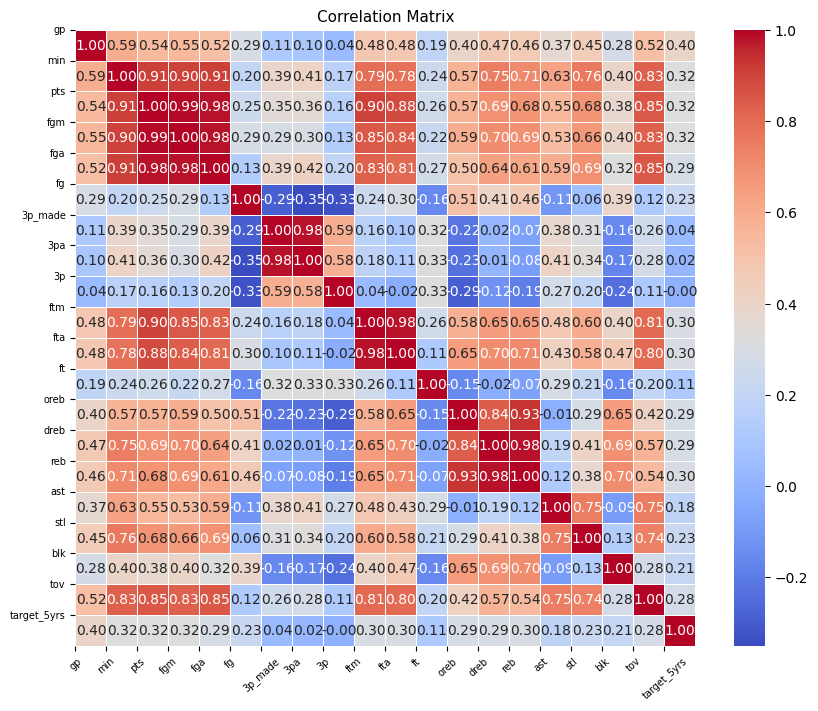

In [ ]:
Utilities.plot_heatmap_for_correlation_matrix(dataFrame)

In [ ]:
Utilities.getHighlyCorrelatedColumns(dataFrame)

array([ True,  True, False, False, False,  True,  True, False,  True,
       False, False,  True,  True, False, False,  True, False,  True,
       False,  True])

In [ ]:
Utilities.normalize(dataFrame.select_dtypes(include='number'))

,gp,min,pts,fgm,fga,fg,3p_made,3pa,3p,ftm,fta,ft,oreb,dreb,reb,ast,stl,blk,tov,target_5yrs
0,-0.343819,0.258349,0.021665,-0.003058,0.090235,-0.190073,0.109678,0.203278,0.058225,0.039206,0.046849,-0.004252,-0.058437,0.145996,0.078203,0.032905,-0.08762,0.008032,0.024744,-0.620482
1,-0.357903,0.245121,0.014392,-0.063664,0.042866,-0.292277,0.196634,0.310971,0.043225,0.169076,0.154692,0.061748,-0.096172,-0.002940,-0.046797,0.202717,0.19238,0.033673,0.094512,-0.620482
2,0.191392,-0.061757,-0.058335,-0.063664,-0.062397,-0.039772,0.066200,0.141740,0.052225,-0.051704,-0.051190,-0.033252,-0.096172,-0.034855,-0.061503,-0.052000,-0.04762,-0.017609,-0.045023,-0.620482
3,-0.033960,-0.159641,-0.040153,-0.033361,-0.020292,-0.031756,-0.064235,-0.042875,0.034225,-0.051704,-0.051190,-0.014252,-0.001833,-0.119961,-0.083562,-0.070868,-0.00762,-0.068891,-0.045023,0.379518
4,-0.174805,-0.162286,-0.083790,-0.104068,-0.151871,0.164637,-0.107713,-0.104414,-0.191775,0.000244,0.007633,-0.029252,-0.001833,-0.056131,-0.039445,-0.118038,-0.12762,0.008032,-0.091535,0.379518
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1334,0.275899,-0.048529,-0.091062,-0.104068,-0.120292,-0.017728,-0.107713,-0.089029,-0.048775,-0.012743,-0.031582,0.088748,-0.115040,-0.130600,-0.135033,0.089509,-0.00762,-0.043250,-0.091535,-0.620482
1336,0.106885,-0.133186,-0.105608,-0.114169,-0.093976,-0.168029,-0.064235,-0.012106,-0.024775,-0.064691,-0.080602,0.090748,-0.115040,-0.098685,-0.112974,0.070641,0.07238,-0.094532,0.024744,0.379518
1337,-0.245227,-0.146413,-0.051062,-0.043462,-0.104502,0.216741,-0.107713,-0.119798,-0.191775,-0.038717,-0.021778,-0.060252,0.092507,0.028975,0.056144,-0.118038,-0.12762,0.008032,-0.068279,-0.620482
1338,-0.118467,-0.149059,-0.083790,-0.093967,-0.109765,-0.005704,-0.107713,-0.089029,-0.091775,-0.012743,-0.002170,-0.078252,-0.152776,-0.173153,-0.171797,0.061207,-0.08762,-0.068891,-0.091535,0.379518


In [ ]:
dataFrame.columns

Index(['name', 'gp', 'min', 'pts', 'fgm', 'fga', 'fg', '3p_made', '3pa', '3p',
       'ftm', 'fta', 'ft', 'oreb', 'dreb', 'reb', 'ast', 'stl', 'blk', 'tov',
       'target_5yrs'],
      dtype='object')

Entropy and Information gain

In [ ]:
class DecisionTree:
  @staticmethod
  def entropy(probability,hasAnySpecialConditions=False):
    if probability == 0 or probability == 1:
          return 0
    else:
        return - (probability * np.log2(probability) + (1 - probability) * np.log2(1-probability))

  @staticmethod
  def informationGain(left,right,hasAnySpecialConditions=False):
    parent = left + right
    pp = 0
    if len(parent) > 0:
      pp = parent.count(1) / len(parent)
    pl = 0
    if len(left) > 0:
      pl = left.count(1) / len(left)
    pr= 0
    if len(right) > 0:
      pr = right.count(1) / len(right)
    informationGainParent = DecisionTree.entropy(pp)
    informationGainLeft = DecisionTree.entropy(pl)
    informationGainRight = DecisionTree.entropy(pr)
    return informationGainParent - len(left) / len(parent) * informationGainLeft - len(right) / len(parent) * informationGainRight

  @staticmethod
  def _findBestSplit(X, y, maxFeaturesToBeSelected):
    featursList = list()
    totalFeatures = len(X[0])

    while len(featursList) <= maxFeaturesToBeSelected:
      featureIndex = random.sample(range(totalFeatures), 1)
      if featureIndex not in featursList:
          featursList.extend(featureIndex)

      bestInformationGain = -9999
      node = None
      for featureIndex in featursList:
        for splitPoint in X[:,featureIndex]:
            leftChild = {'X': [], 'y': []}
            rightChild = {'X': [], 'y': []}

            if type(splitPoint) == int or  type(splitPoint)==float:
                for idx, val in enumerate(X[:,featureIndex]):
                    if val <= splitPoint:
                        leftChild['X'] += [X[idx]]
                        leftChild['y'] += [y[idx]]
                    else:
                        rightChild['X'] += [X[idx]]
                        rightChild['y'] += [y[idx]]

            else:
                for idx, val in enumerate(X[:,featureIndex]):
                    if val == splitPoint:
                        leftChild['X'] += [X[idx]]
                        leftChild['y'] += [y[idx]]
                    else:
                        rightChild['X'] += [X[idx]]
                        rightChild['y'] += [y[idx]]

            splitInformationGain = DecisionTree.informationGain(leftChild['y'], rightChild['y'])
            if splitInformationGain > bestInformationGain:
                bestInformationGain = splitInformationGain
                leftChild['X'] = np.array(leftChild['X'])
                rightChild['X'] = np.array(rightChild['X'])
                node = {'informationGain': splitInformationGain,
                        'leftChild': leftChild,
                        'rightChild': rightChild,
                        'splitPoint': splitPoint,
                        'featureIndex': featureIndex}
    return node

  @staticmethod
  def findBestSplit(X, y, maxFeaturesToBeSelected):
    bestInformationGain = -9999
    node = None
    n_samples, n_features = X.shape

    # Select subset of features randomly
    features = np.random.choice(n_features, maxFeaturesToBeSelected, replace=True)

    for featureIndex in features:
      # Sort the data along selected feature
      sorted_indices = np.argsort(X[:, featureIndex])
      sorted_X, sorted_y = X[sorted_indices], y[sorted_indices]

      for i in range(1, n_samples):
        # only consider split points where the value changes
        if sorted_y[i] != sorted_y[i - 1]:
          splitPoint = (sorted_X[i, featureIndex] + sorted_X[i - 1, featureIndex]) / 2  # get middle X point
          left_y, right_y = sorted_y[:i], sorted_y[i:]

          splitInformationGain = DecisionTree.informationGain(list(left_y), list(right_y))

          if splitInformationGain > bestInformationGain:
            bestInformationGain = splitInformationGain
            left_indices, right_indices = sorted_indices[:i], sorted_indices[i:]
            node = {'informationGain': splitInformationGain,
                    'leftChild': {'X': X[left_indices], 'y': y[left_indices]},
                    'rightChild': {'X': X[right_indices], 'y': y[right_indices]},
                    'splitPoint': splitPoint,
                    'featureIndex': featureIndex}

    return node

  @staticmethod
  def terminalTreeNode(child):
    y = child['y']
    prediction = statistics.mode(y)
    return prediction

  @staticmethod
  def _splitTreeNode(node, maxFeatures, minSampleSplit, maxDepth, depth,hasAnySpecialConditions=False):
    leftChild = node['leftChild']
    rightChild = node['rightChild']

    del(node['leftChild'])
    del(node['rightChild'])

    if len(leftChild['y']) == 0 or len(rightChild['y']) == 0:
        emptyChild = {'y': leftChild['y'] + rightChild['y']}
        node['leftSplit'] = DecisionTree.terminalTreeNode(emptyChild)
        node['rightSplit'] = DecisionTree.terminalTreeNode(emptyChild)
        return

    if depth >= maxDepth:
        node['leftSplit'] = DecisionTree.terminalTreeNode(leftChild)
        node['rightSplit'] = DecisionTree.terminalTreeNode(rightChild)
        return node

    if len(leftChild['X']) <= minSampleSplit:
        node['leftSplit'] = node['rightSplit'] = DecisionTree.terminalTreeNode(leftChild)
    else:
        node['leftSplit'] = DecisionTree.findBestSplit(leftChild['X'], leftChild['y'], maxFeatures)
        DecisionTree.splitTreeNode(node['leftSplit'], maxDepth, minSampleSplit, maxDepth, depth + 1)
    if len(rightChild['X']) <= minSampleSplit:
        node['rightSplit'] = node['leftSplit'] = DecisionTree.terminalTreeNode(rightChild)
    else:
        node['rightSplit'] = DecisionTree.findBestSplit(rightChild['X'], rightChild['y'], maxFeatures)
        DecisionTree.splitTreeNode(node['rightSplit'], maxFeatures, minSampleSplit, maxDepth, depth + 1)

  @staticmethod
  def splitTreeNode(node, maxFeatures, minSampleSplit, maxDepth, depth,hasAnySpecialConditions=False):
    if node is None:
      return

    # Extract left and right children from the current node. Return None if key doesn't exist
    leftChild = node.get('leftChild')
    rightChild = node.get('rightChild')

    # If either child is None, no further splitting is possible
    if leftChild is None or rightChild is None:
      return

    # Base case: if the tree has reached its maximum depth
    if depth >= maxDepth:
      node['leftSplit'] = DecisionTree.terminalTreeNode(leftChild)
      node['rightSplit'] = DecisionTree.terminalTreeNode(rightChild)
      return

    # Handle the left child
    if len(leftChild['y']) <= minSampleSplit:
      node['leftSplit'] = DecisionTree.terminalTreeNode(leftChild)
    else:
      node['leftSplit'] = DecisionTree.findBestSplit(leftChild['X'], leftChild['y'], maxFeatures)
      DecisionTree.splitTreeNode(node['leftSplit'], maxFeatures, minSampleSplit, maxDepth, depth + 1)

    # Handle the right child
    if len(rightChild['y']) <= minSampleSplit:
      node['rightSplit'] = DecisionTree.terminalTreeNode(rightChild)
    else:
      node['rightSplit'] = DecisionTree.findBestSplit(rightChild['X'], rightChild['y'], maxFeatures)
      DecisionTree.splitTreeNode(node['rightSplit'], maxFeatures, minSampleSplit, maxDepth, depth + 1)


  @staticmethod
  def buildTree(X, y, maxDepth, minSamplesSplit, maxFeatures):
    rootNode = DecisionTree.findBestSplit(X, y, maxFeatures)
    DecisionTree.splitTreeNode(rootNode, maxFeatures, minSamplesSplit, maxDepth, 1)
    return rootNode

  @staticmethod
  def predictTree(tree, X):
    featureIndex = tree['featureIndex']
    # print(type(X[featureIndex]), X[featureIndex])
    # print(type(tree['splitPoint']), tree['splitPoint'])
    if X[featureIndex] <= tree['splitPoint']:
        if type(tree['leftSplit']) != dict:
            return tree['leftSplit']
        else:
            return DecisionTree.predictTree(tree['leftSplit'], X)
    else:
        if type(tree['rightSplit']) != dict:
           return tree['rightSplit']
        else:
           return DecisionTree.predictTree(tree['rightSplit'], X)

In [ ]:
class BootStrap:
  @staticmethod
  def bootstrapSample(X, y):
    selectedIndices = list(np.random.choice(range(len(X)), len(X), replace = True))
    outOfBagIndices = [i for i in range(len(X)) if i not in selectedIndices]
    XTrain = X.iloc[selectedIndices].values
    yTrain = y[selectedIndices]
    XTest = X.iloc[outOfBagIndices].values
    yTest = y[outOfBagIndices]
    return XTrain, yTrain, XTest, yTest

  @staticmethod
  def testError(model,X,y):
    predictions = [DecisionTree.predictTree(model, X) for X in X]
    missClassifiedPoints = 0
    for p,l in zip(predictions,y):
      if p!=l:
        missClassifiedPoints+=1
    print("Error ", missClassifiedPoints/len(X))
    return missClassifiedPoints/len(X)

In [ ]:
class RandomForest:
  @staticmethod
  def buildRandomForestTree(X,y,number_of_estimators,max_depth_of_tree,min_node_size_to_split,max_features_to_be_selected):
    decision_tree_list = list()
    error_list = list()

    for cur_estimator in range(number_of_estimators):
      XTrain,yTrain,XTest,yTest = BootStrap.bootstrapSample(X,y)
      cur_tree = DecisionTree.buildTree(XTrain,yTrain,max_depth_of_tree,min_node_size_to_split,max_features_to_be_selected)
      decision_tree_list.append(cur_tree)
      error_list.append(BootStrap.testError(cur_tree,XTest,yTest))

    print("Test error (Out of bag estimate): {:.2f}".format(np.mean(error_list)))
    return decision_tree_list

  @staticmethod
  def predictRandomForest(treeList, XTest,hasAnySpecialConditions=False):
    predList = list()
    for i in range(len(XTest)):
        ensemblePreds = [DecisionTree.predictTree(tree, XTest.values[i]) for tree in treeList]
        finalPred = max(ensemblePreds, key = ensemblePreds.count)
        predList.append(finalPred)
    return np.array(predList)

Here is the graph and printing of our custom random forest implementation without sklearn

Error  0.4156769596199525
Error  0.32293986636971045
Error  0.41002277904328016
Error  0.3400900900900901
Error  0.4135514018691589
Error  0.4376417233560091
Error  0.3701923076923077
Error  0.39080459770114945
Error  0.3888888888888889
Error  0.4072398190045249
Error  0.38826185101580135
Error  0.4073275862068966
Error  0.35398230088495575
Error  0.4214123006833713
Error  0.3824175824175824
Error  0.334841628959276
Error  0.35730858468677495
Error  0.3689095127610209
Error  0.44789356984478934
Error  0.4
Error  0.4113636363636364
Error  0.42630385487528344
Error  0.3920704845814978
Error  0.3978021978021978
Error  0.39635535307517084
Error  0.39631336405529954
Error  0.40487804878048783
Error  0.401330376940133
Error  0.38611713665943603
Error  0.40189125295508277
Error  0.41402714932126694
Error  0.33710407239819007
Error  0.3288888888888889
Error  0.3627906976744186
Error  0.3303964757709251
Error  0.4327354260089686
Error  0.3864168618266979
Error  0.38084632516703787
Error  0.4162

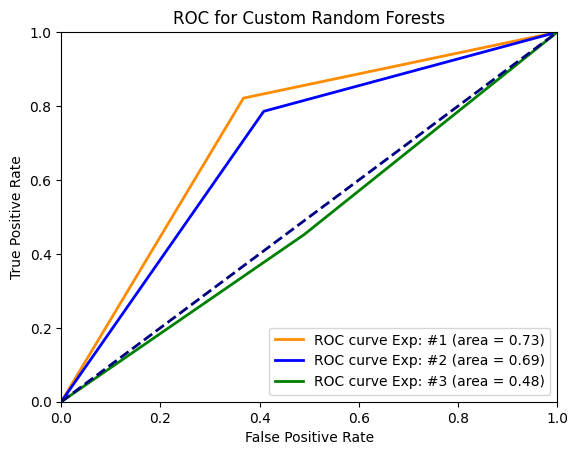

Experiment Number | Parameters (Model)                                          | Results (Accuracy, Precision, Recall, F1-Score)                  
------------------+-------------------------------------------------------------+------------------------------------------------------------------
1                 | Estimators: 125, Depth: 5, Min Split: 18, Max Features: 3   | Accuracy: 0.752, Precision: 0.793, Recall: 0.821, F1-Score: 0.807
2                 | Estimators: 80, Depth: 6, Min Split: 4, Max Features: 12    | Accuracy: 0.714, Precision: 0.767, Recall: 0.786, F1-Score: 0.776
3                 | Estimators: 152, Depth: 13, Min Split: 17, Max Features: 18 | Accuracy: 0.474, Precision: 0.613, Recall: 0.452, F1-Score: 0.521


In [ ]:
def print_table(dataFrame):
    colWidths = {}

    for columns in dataFrame.columns:
        maxLength = max(dataFrame[columns].astype(str).apply(len).max(), len(columns))
        colWidths[columns] = maxLength

    headerRow = ""
    for columns in dataFrame.columns:
        headerRow += columns.ljust(colWidths[columns]) + " | "
    headerRow = headerRow[:-3]

    dividerRow = ""
    for columns in dataFrame.columns:
        dividerRow += "-" * colWidths[columns] + "-+-"
    dividerRow = dividerRow[:-3]

    print(headerRow)
    print(dividerRow)

    for i, r in dataFrame.iterrows():
        rowString = ""
        for columns in dataFrame.columns:
            rowString += str(r[columns]).ljust(colWidths[columns]) + " | "
        rowString = rowString[:-3]
        print(rowString)

def run_and_plot_custom_random_forest(custom_rf_parameters):
  res = []
  rocsForPlotting = []

  for idx, params in enumerate(custom_rf_parameters):
    numberOfEstimators = params['numberOfEstimators']
    maxDepthOfTree = params['maxDepthOfTree']
    minNodeSizeToSplit = params['minNodeSizeToSplit']
    maxFeaturesToBeSelected = params['maxFeaturesToBeSelected']

    XTrain, yTrain, XTest, yTest = Utilities.testTrainSplit(dataFrame, "target_5yrs")
    model = RandomForest.buildRandomForestTree(XTrain, yTrain, numberOfEstimators, maxDepthOfTree, minNodeSizeToSplit, maxFeaturesToBeSelected)
    predictions = RandomForest.predictRandomForest(model, XTest)

    # Replace None with a random choice of 0 or 1, if any Nones exist
    def replace_none_with_random_binary(array):
      return [random.choice([0, 1]) if x is None else x for x in array]

    yTest= replace_none_with_random_binary(yTest)
    predictions = replace_none_with_random_binary(predictions)

    # Calculate metrics
    acc = accuracy_score(yTest, predictions)
    pr = precision_score(yTest, predictions)
    re = recall_score(yTest, predictions)
    fStat = f1_score(yTest, predictions)

    res.append({
      "Experiment Number": idx + 1,
      "Parameters (Model)": f"Estimators: {numberOfEstimators}, Depth: {maxDepthOfTree}, Min Split: {minNodeSizeToSplit}, Max Features: {maxFeaturesToBeSelected}",
      "Results (Accuracy, Precision, Recall, F1-Score)": f"Accuracy: {acc:.3f}, Precision: {pr:.3f}, Recall: {re:.3f}, F1-Score: {fStat:.3f}"
    })

    # Compute ROC metrics and store
    falsePositiveRate, truePositiveRate, thresholds = roc_curve(yTest, predictions)
    areaUnderCurve = auc(falsePositiveRate, truePositiveRate)
    rocsForPlotting.append((falsePositiveRate, truePositiveRate, areaUnderCurve))

  # Plot all ROC curves
  pyplot.figure()
  colors = ['darkorange', 'blue', 'green', 'red', 'purple']  # Add more colors if needed
  for i, (falsePositiveRate, truePositiveRate, areaUnderCurve) in enumerate(rocsForPlotting):
    pyplot.plot(falsePositiveRate, truePositiveRate, color=colors[i % len(colors)], lw=2, label=f'ROC curve Exp: #{i + 1} (area = {areaUnderCurve:.2f})')
  pyplot.xlim([0, 1])
  pyplot.ylim([0, 1])
  pyplot.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  pyplot.xlabel('False Positive Rate')
  pyplot.ylabel('True Positive Rate')
  pyplot.title('ROC for Custom Random Forests')
  pyplot.legend(loc="lower right")
  pyplot.show()

  # Display all res in a table
  resultsDataFrame = pd.DataFrame(res)
  print_table(resultsDataFrame)

run_and_plot_custom_random_forest(custom_rf_parameters)

In [ ]:
class ModelTrainerSklearnPlots:
  def __init__(self, randomState, X, y,hasAnySpecialConditions=False):
      self.random_state = randomState
      self.models = {}
      self.X = X
      self.y = y

  def run_adaboost(self, n_estimators, learning_rate, testSize=0.2):
      XTrain, XTest, yTrain, yTest = train_test_split(self.X, self.y, test_size=testSize, random_state=self.random_state)
      classifier = AdaBoostClassifier(n_estimators=n_estimators, learning_rate=learning_rate, random_state=self.random_state)
      classifier.fit(XTrain, yTrain)
      yPredection = classifier.predict(XTest)
      report = classification_report(yTest, yPredection, output_dict=True)
      self.models['ADABoost n_estimators=' + str(n_estimators) + " learning_rate=" + str(learning_rate)] = classifier
      return pd.DataFrame(report).transpose()

  def run_xgboost(self, n_estimators, learning_rate, testSize=0.2):
      XTrain, XTest, yTrain, yTest = train_test_split(self.X, self.y, test_size=testSize, random_state=self.random_state)
      classifier = XGBClassifier(n_estimators=n_estimators, learning_rate=learning_rate, random_state=self.random_state, use_label_encoder=False, eval_metric='logloss')
      classifier.fit(XTrain, yTrain)
      yPredection = classifier.predict(XTest)
      report = classification_report(yTest, yPredection, output_dict=True)
      self.models['XGBoost n_estimators=' + str(n_estimators) + " learning_rate=" + str(learning_rate)] = classifier
      return pd.DataFrame(report).transpose()

  def run_bagging(self, n_estimators, test_size=0.2):
      xTrain, xTest, yTrain, yTest = train_test_split(self.X, self.y, test_size=test_size, random_state=self.random_state)
      classification = BaggingClassifier(n_estimators=n_estimators, random_state=self.random_state)
      classification.fit(xTrain, yTrain)
      yPred = classification.predict(xTest)
      report = classification_report(yTest, yPred, output_dict=True)
      self.models['Bagging n_estimators=' + str(n_estimators)] = classification
      return pd.DataFrame(report).transpose()


  def plot_all_roc_curves(self):
    pyplot.figure(figsize=(10, 8))

    for modelName, classification in self.models.items():
        XTrain, XTest, yTrain, yTest = train_test_split(self.X, self.y, test_size=0.2, random_state=self.random_state)
        classification.fit(XTrain, yTrain)
        yProbs = classification.predict_proba(XTest)[:, 1]

        falsePositiveRate, truePositiveRate, _ = roc_curve(yTest, yProbs)
        areaUnderCurve = auc(falsePositiveRate, truePositiveRate)

        pyplot.plot(falsePositiveRate, truePositiveRate, lw=2, label=f'{modelName} (area = {areaUnderCurve:.2f})')

    pyplot.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    pyplot.xlim([0, 1])
    pyplot.ylim([0, 1])
    pyplot.xlabel('False Positive Rate')
    pyplot.ylabel('True Positive Rate')
    pyplot.title('ROC Curves & Areas w/ Sklearn')
    pyplot.legend(loc="lower right")
    pyplot.show()

Sklearn Implementations. We are implementing Random Forests from scratch, but XGBoost, ADABoost, and Bagging by hand.

Experiment Number | Parameters (Model)                             | Results (Accuracy, Precision, Recall, F1-Score)                      
------------------+------------------------------------------------+----------------------------------------------------------------------
1                 | AdaBoost (n_estimators=50, learning_rate=0.5)  | Accuracy: 0.7218, Precision: 0.7159, Recall: 0.7218, F1-Score: 0.71  
2                 | AdaBoost (n_estimators=100, learning_rate=1.0) | Accuracy: 0.688, Precision: 0.68, Recall: 0.688, F1-Score: 0.6811    
3                 | XGBoost (n_estimators=100, learning_rate=0.1)  | Accuracy: 0.6692, Precision: 0.6606, Recall: 0.6692, F1-Score: 0.6624
4                 | XGBoost (n_estimators=200, learning_rate=0.05) | Accuracy: 0.6917, Precision: 0.6865, Recall: 0.6917, F1-Score: 0.6881
5                 | Bagging (n_estimators=5)                       | Accuracy: 0.5977, Precision: 0.5969, Recall: 0.5977, F1-Score: 0.5973
6                 | Bagging

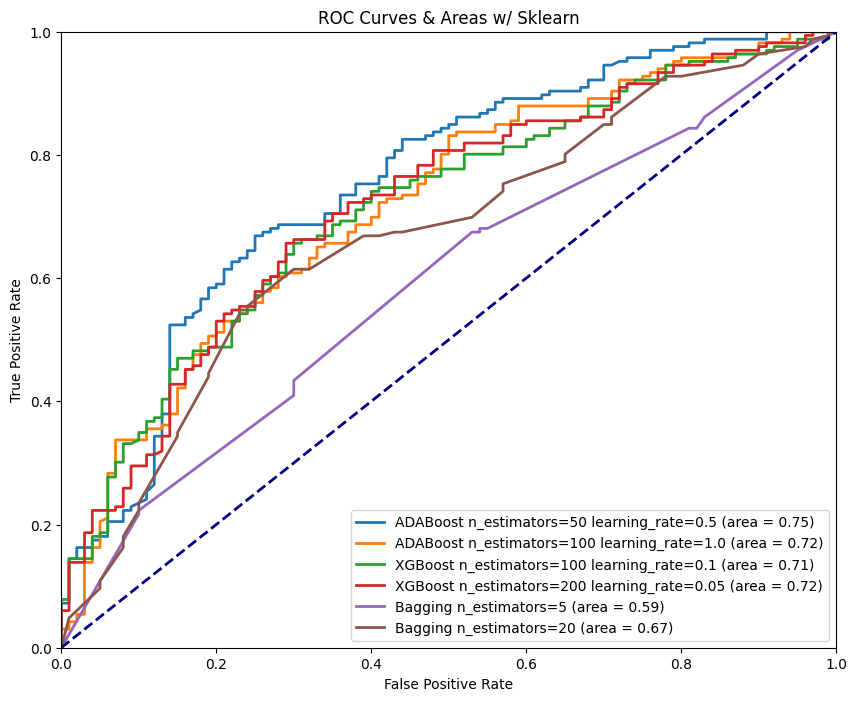

In [ ]:
X = dataFrame.iloc[:, 1:-1] # X feature columns
y = dataFrame.iloc[:, -1] # Last column (target_5yrs) for y

mt = ModelTrainerSklearnPlots(3, X, y)


results_df = pd.DataFrame(columns=['Experiment Number', 'Parameters (Model)', 'Results (Accuracy, Precision, Recall, F1-Score)'])
experiment_counter = 1
def add_results_to_df(report, model_name, params):
    global experiment_counter
    paramsString = ', '.join([f"{k}={v}" for k, v in params.items()])
    results_str = f"Accuracy: {round(report.loc['accuracy', 'precision'], 4)}, " \
                  f"Precision: {round(report.loc['weighted avg', 'precision'], 4)}, " \
                  f"Recall: {round(report.loc['weighted avg', 'recall'], 4)}, " \
                  f"F1-Score: {round(report.loc['weighted avg', 'f1-score'], 4)}"
    results_df.loc[experiment_counter] = [
        experiment_counter,
        f"{model_name} ({paramsString})",
        results_str
    ]
    experiment_counter += 1

for params in ada_parameters:
    ada_report = mt.run_adaboost(**params)
    add_results_to_df(ada_report, 'AdaBoost', params)

for params in xgb_parameters:
    xgb_report = mt.run_xgboost(**params)
    add_results_to_df(xgb_report, 'XGBoost', params)

for params in bag_parameters:
    bag_report = mt.run_bagging(**params)
    add_results_to_df(bag_report, 'Bagging', params)


#print("These experiments are done with a 80/20 train/test split.")
run_and_plot_custom_random_forest
print_table(results_df)
mt.plot_all_roc_curves()